## Part 0: Face Detector

## 0.1 building blocks

In [1]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class ConvBNAct(nn.Module):
  #default general-purpose building block, k kernel size, p padding, s stride
    def __init__(self, in_ch: int, out_ch: int, k: int = 1, s: int = 1, p: int | None = None, groups: int = 1):
        super().__init__()
        if p is None:
            p = k // 2
        self.conv = nn.Conv2d(in_ch, out_ch, k, s, p, groups=groups, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.SiLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.act(self.bn(self.conv(x)))

In [3]:
class DWConvBNAct(nn.Module):
    #"""Depthwise (+ pointwise via separate layer when needed)."""
    #Depthwise convolution = a convolution that does spatial filtering channel-by-channel with no channel mixing
    def __init__(self, in_ch: int, k: int = 3, s: int = 1, p: int | None = None, dilation: int = 1):
        super().__init__()
        if p is None:
            p = (k // 2) * dilation
        self.dw = ConvBNAct(in_ch, in_ch, k=k, s=s, p=p, groups=in_ch)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dw(x)
    #Because it doesn’t mix channels, depthwise is usually followed by a pointwise 1×1 conv (which does mix channels). Together they’re called a depthwise-separable conv.

In [4]:
class DWSeparableConv(nn.Module):
    #"""Depthwise 3x3 + Pointwise 1x1."""
    def __init__(self, in_ch: int, out_ch: int, k: int = 3, s: int = 1, dilation: int = 1):
        super().__init__()
        p = (k // 2) * dilation
        self.dw = nn.Conv2d(in_ch, in_ch, k, s, p, groups=in_ch, bias=False, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(in_ch)
        self.act1 = nn.SiLU(inplace=True)
        self.pw = nn.Conv2d(in_ch, out_ch, 1, 1, 0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.act2 = nn.SiLU(inplace=True)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.act1(self.bn1(self.dw(x)))
        x = self.act2(self.bn2(self.pw(x)))
        return x

In [5]:
class ResidualBlock(nn.Module):
  #two DWSeparableConv layers with a skip connection (x + F(x))
    def __init__(self, ch: int, dilation: int = 1):
        super().__init__()
        self.conv1 = DWSeparableConv(ch, ch, k=3, s=1, dilation=dilation)
        self.conv2 = DWSeparableConv(ch, ch, k=3, s=1, dilation=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.conv2(self.conv1(x))

## 0.2 Backbone

In [6]:
# Backbone (Stem + S2/S3/S4 stages)
# Strides: Stem:2 → S2:4 → S3:8 → S4:16

class TinyBackbone(nn.Module):
    def __init__(self, width_mult: float = 1.0, depths: Tuple[int, int, int] = (2, 3, 3)):
        super().__init__()
        ch16 = max(8, int(16 * width_mult))
        ch32 = max(16, int(32 * width_mult))
        ch64 = max(24, int(64 * width_mult))
        ch128 = max(32, int(128 * width_mult))

        # Stem: 3→16, stride 2
        self.stem_dw = DWConvBNAct(3, k=3, s=2)   # (B,3,512,512)→(B,3,256,256)
        self.stem_pw = ConvBNAct(3, ch16, k=1, s=1, p=0)    # (B,3,256,256)→(B,ch16,256,256)

        # S2: stride 4
        self.s2_down = DWSeparableConv(ch16, ch32, k=3, s=2)    # (B,ch16,256,256)→(B,ch32,128,128)
        self.s2_blocks = nn.Sequential(*[ResidualBlock(ch32) for _ in range(depths[0])])

        # S3: stride 8
        self.s3_down = DWSeparableConv(ch32, ch64, k=3, s=2) # (B,ch32,128,128)→(B,ch64,64,64)
        self.s3_blocks = nn.Sequential(*[ResidualBlock(ch64) for _ in range(depths[1])])

        # S4: stride 16, use dilation inside blocks to expand RF
        self.s4_down = DWSeparableConv(ch64, ch128, k=3, s=2) # (B,ch64,64,64)→(B,ch128,32,32)
        self.s4_blocks = nn.Sequential(*[ResidualBlock(ch128, dilation=2) for _ in range(depths[2])])

        self.out_channels = (ch32, ch64, ch128) # for FPN

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = self.stem_pw(self.stem_dw(x)) # (B,ch16,256,256)
        c3 = self.s2_blocks(self.s2_down(x)) # (B,ch32,128,128)
        c4 = self.s3_blocks(self.s3_down(c3)) # (B,ch64, 64, 64)
        c5 = self.s4_blocks(self.s4_down(c4)) # (B,ch128,32, 32)
        return c3, c4, c5

## 0.3 FPN

In [7]:
# Lightweight FPN (P3,P4,P5). We unify channels to fpn_ch.
# -----------------------------------------------------------------------------
#TinyBackbone outputs c3/c4/c5 at strides 4/8/16.
#FPN fuses them into p3/p4/p5 with the same strides.
#We intentionally start at stride-4 to help small faces; the “P3” name is just a label—the stride is what defines the scale.

class LiteFPN(nn.Module):
    def __init__(self, in_channels: Tuple[int, int, int], fpn_ch: int = 96):
        super().__init__()
        c3, c4, c5 = in_channels
        self.l3 = ConvBNAct(c3, fpn_ch, k=1, s=1, p=0)
        self.l4 = ConvBNAct(c4, fpn_ch, k=1, s=1, p=0)
        self.l5 = ConvBNAct(c5, fpn_ch, k=1, s=1, p=0)
        self.smooth3 = DWSeparableConv(fpn_ch, fpn_ch, k=3, s=1)
        self.smooth4 = DWSeparableConv(fpn_ch, fpn_ch, k=3, s=1)
        self.smooth5 = DWSeparableConv(fpn_ch, fpn_ch, k=3, s=1)

    def forward(self, c3: torch.Tensor, c4: torch.Tensor, c5: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        p5 = self.l5(c5)
        p4 = self.l4(c4) + F.interpolate(p5, size=c4.shape[-2:], mode="nearest")
        p3 = self.l3(c3) + F.interpolate(p4, size=c3.shape[-2:], mode="nearest")
        return self.smooth3(p3), self.smooth4(p4), self.smooth5(p5)

## 0.4 Head

In [8]:
# Detection Head (shared across P3,P4,P5): cls (1), box (4), ctr (1)
# -----------------------------------------------------------------------------

class Head(nn.Module):
    def __init__(self, in_ch: int, feat_ch: int, num_levels: int = 3, num_classes: int = 1, depth: int = 2):
        super().__init__()
        self.cls_tower = nn.Sequential(*[
            ConvBNAct(in_ch if i == 0 else feat_ch, feat_ch, k=3, s=1, p=1) for i in range(depth)
        ])
        self.box_tower = nn.Sequential(*[
            ConvBNAct(in_ch if i == 0 else feat_ch, feat_ch, k=3, s=1, p=1) for i in range(depth)
        ])
        self.cls_pred = nn.Conv2d(feat_ch, num_classes, 3, padding=1)
        self.box_pred = nn.Conv2d(feat_ch, 4,          3, padding=1)
        self.ctr_pred = nn.Conv2d(feat_ch, 1,          3, padding=1)
        self.scales   = nn.ParameterList([nn.Parameter(torch.tensor(1.0)) for _ in range(num_levels)])

        prior = 0.01
        bias_init = -math.log((1 - prior) / prior)
        nn.init.constant_(self.cls_pred.bias, bias_init)

    def forward(self, feats):
        cls_out, box_out, ctr_out = [], [], []
        for lvl, f in enumerate(feats):
            cfeat = self.cls_tower(f)
            bfeat = self.box_tower(f)
            c = self.cls_pred(cfeat)                 # (B,1,H,W)
            box_logits = self.box_pred(bfeat)        # (B,4,H,W)
            b = torch.exp(self.scales[lvl] * box_logits)  # positive ltrb
            q = self.ctr_pred(bfeat)                 # (B,1,H,W)
            cls_out.append(c); box_out.append(b); ctr_out.append(q)
        return {"cls": cls_out, "box": box_out, "ctr": ctr_out}


## 0.5 Full Model

In [9]:
class TinyFaceDetector(nn.Module):
    def __init__(self, width_mult: float = 1.0, depths: Tuple[int, int, int] = (2, 3, 3), fpn_ch: int = 96):
        super().__init__()
        self.backbone = TinyBackbone(width_mult=width_mult, depths=depths)
        self.fpn = LiteFPN(self.backbone.out_channels, fpn_ch=fpn_ch)
        self.head = Head(in_ch=fpn_ch, feat_ch=fpn_ch, num_levels=3, num_classes=1, depth=2)

        # strides of P3,P4,P5 relative to input 512: 512→(128,64,32) ⇒ strides (4,8,16)
        self.strides = (4, 8, 16)

    def forward(self, x: torch.Tensor) -> Dict[str, List[torch.Tensor]]:
        c3, c4, c5 = self.backbone(x)
        p3, p4, p5 = self.fpn(c3, c4, c5)
        out = self.head([p3, p4, p5])
        return out # {"cls":[P3,P4,P5], "box":[P3,P4,P5], "ctr":[P3,P4,P5]}

## 0.6 Target assignment

In [10]:
# make sure these are executed BEFORE compute_targets
from dataclasses import dataclass
from typing import List, Tuple
import torch

@dataclass
class Targets:
    cls: List[torch.Tensor]  # per level (B,1,H,W)
    box: List[torch.Tensor]  # per level (B,4,H,W)
    ctr: List[torch.Tensor]  # per level (B,1,H,W)

def compute_targets(
    gt_boxes: List[torch.Tensor],
    feat_shapes: List[Tuple[int, int]],
    strides: Tuple[int, int, int] = (4, 8, 16),
    center_sampling_radius: float = 1.5,
    size_ranges: Tuple[Tuple[float, float], Tuple[float, float], Tuple[float, float]] = ((0, 64), (48, 128), (96, 1e8)),
) -> Targets:
    B = len(gt_boxes)
    device = gt_boxes[0].device if B > 0 and gt_boxes[0] is not None else torch.device("cpu")

    outs_cls: List[torch.Tensor] = []
    outs_box: List[torch.Tensor] = []
    outs_ctr: List[torch.Tensor] = []

    for lvl, ((H, W), s) in enumerate(zip(feat_shapes, strides)):
        locs = locations_for_level(H, W, s, device=device).view(-1, 2)  # (HW,2)
        HW = H * W

        cls_t = torch.zeros((B, 1, H, W), device=device)
        box_t = torch.zeros((B, 4, H, W), device=device)
        ctr_t = torch.zeros((B, 1, H, W), device=device)

        size_min, size_max = size_ranges[lvl]

        for b in range(B):
            gtb = gt_boxes[b]
            if gtb is None or gtb.numel() == 0:
                continue

            x1, y1, x2, y2 = gtb[:, 0], gtb[:, 1], gtb[:, 2], gtb[:, 3]
            w = (x2 - x1).clamp_min(1e-6)
            h = (y2 - y1).clamp_min(1e-6)
            area = w * h
            size = torch.maximum(w, h)

            box_level_mask = (size > size_min) & (size <= size_max)
            if not box_level_mask.any():
                continue
            x1, y1, x2, y2 = x1[box_level_mask], y1[box_level_mask], x2[box_level_mask], y2[box_level_mask]
            area = area[box_level_mask]
            N = x1.numel()

            locs_exp = locs[None, :, :].expand(N, HW, 2)
            x1e = x1[:, None]; y1e = y1[:, None]; x2e = x2[:, None]; y2e = y2[:, None]

            l = (locs_exp[..., 0] - x1e)
            t = (locs_exp[..., 1] - y1e)
            r = (x2e - locs_exp[..., 0])
            b_ = (y2e - locs_exp[..., 1])

            inside = (l >= 0) & (t >= 0) & (r >= 0) & (b_ >= 0)

            if center_sampling_radius > 0:
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2
                rs = center_sampling_radius * s
                x1c = torch.maximum(cx - rs, x1); y1c = torch.maximum(cy - rs, y1)
                x2c = torch.minimum(cx + rs, x2); y2c = torch.minimum(cy + rs, y2)
                x1c = x1c[:, None]; y1c = y1c[:, None]; x2c = x2c[:, None]; y2c = y2c[:, None]
                inside_center = (locs_exp[..., 0] >= x1c) & (locs_exp[..., 0] <= x2c) & \
                                (locs_exp[..., 1] >= y1c) & (locs_exp[..., 1] <= y2c)
                inside = inside & inside_center

            if not inside.any():
                continue

            areas = area[:, None].expand(N, HW)
            areas = torch.where(inside, areas, torch.full_like(areas, float('inf')))
            min_area, min_inds = areas.min(dim=0)  # (HW)
            pos = torch.isfinite(min_area)         # (HW,)

            if pos.sum() == 0:
                continue

            # ---------- CHANGED: use flat integer indices + index_copy_/index_fill_ ----------
            ar = torch.arange(HW, device=device)
            min_inds = min_inds.to(device=device, dtype=torch.long)
            pos_idx = torch.nonzero(pos, as_tuple=False).squeeze(1).to(device=device, dtype=torch.long)

            # distances for selected GT at each location (full fields)
            l_all = l[min_inds, ar]
            t_all = t[min_inds, ar]
            r_all = r[min_inds, ar]
            b_all = b_[min_inds, ar]

            # gather positive values using integer indices
            l_vals = l_all[pos_idx]; t_vals = t_all[pos_idx]
            r_vals = r_all[pos_idx]; b_vals = b_all[pos_idx]

            # centerness for positives
            ctr_pos = torch.sqrt(
                (torch.minimum(l_vals, r_vals) / torch.maximum(l_vals, r_vals)).clamp_min(1e-6) *
                (torch.minimum(t_vals, b_vals) / torch.maximum(t_vals, b_vals)).clamp_min(1e-6)
            )

            # flat views
            cls_flat = cls_t[b, 0].view(-1)
            bx0_flat = box_t[b, 0].view(-1)
            bx1_flat = box_t[b, 1].view(-1)
            bx2_flat = box_t[b, 2].view(-1)
            bx3_flat = box_t[b, 3].view(-1)
            ctr_flat = ctr_t[b, 0].view(-1)

            # write with integer indices (no boolean masks)
            cls_flat.index_fill_(0, pos_idx, 1.0)
            bx0_flat.index_copy_(0, pos_idx, l_vals)
            bx1_flat.index_copy_(0, pos_idx, t_vals)
            bx2_flat.index_copy_(0, pos_idx, r_vals)
            bx3_flat.index_copy_(0, pos_idx, b_vals)
            ctr_flat.index_copy_(0, pos_idx, ctr_pos)
            # ---------- /CHANGED ------------------------------------------------------------

        outs_cls.append(cls_t)
        outs_box.append(box_t)
        outs_ctr.append(ctr_t)

    return Targets(cls=outs_cls, box=outs_box, ctr=outs_ctr)


## 0.7 Losses

In [11]:
# Losses (Focal + IoU + BCE for centerness) — scaffolding (Focal + IoU + BCE for centerness) — scaffolding
# -----------------------------------------------------------------------------

class FocalLoss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, reduction: str = "sum"):
        super().__init__()
        self.alpha, self.gamma, self.reduction = alpha, gamma, reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # logits: (B,1,H,W), targets: {0,1}
        p = torch.sigmoid(logits)
        pt = p * targets + (1 - p) * (1 - targets)
        w = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        loss = -w * (1 - pt).pow(self.gamma) * torch.log(pt.clamp_min(1e-6))
        if self.reduction == "sum":
            return loss.sum()
        elif self.reduction == "mean":
            return loss.mean()
        return loss


def iou_loss(pred_xyxy: torch.Tensor, tgt_xyxy: torch.Tensor, reduction: str = "mean") -> torch.Tensor:
    # pred/tgt: (..., 4)
    x1 = torch.max(pred_xyxy[..., 0], tgt_xyxy[..., 0])
    y1 = torch.max(pred_xyxy[..., 1], tgt_xyxy[..., 1])
    x2 = torch.min(pred_xyxy[..., 2], tgt_xyxy[..., 2])
    y2 = torch.min(pred_xyxy[..., 3], tgt_xyxy[..., 3])
    inter = (x2 - x1).clamp_min(0) * (y2 - y1).clamp_min(0)
    area_p = (pred_xyxy[..., 2] - pred_xyxy[..., 0]).clamp_min(0) * (pred_xyxy[..., 3] - pred_xyxy[..., 1]).clamp_min(0)
    area_t = (tgt_xyxy[..., 2] - tgt_xyxy[..., 0]).clamp_min(0) * (tgt_xyxy[..., 3] - tgt_xyxy[..., 1]).clamp_min(0)
    union = area_p + area_t - inter + 1e-6
    iou = inter / union
    loss = 1 - iou
    return loss.mean() if reduction == "mean" else loss.sum()

def giou_loss(pred_xyxy: torch.Tensor, tgt_xyxy: torch.Tensor, reduction: str = "sum") -> torch.Tensor:
    """
    pred_xyxy, tgt_xyxy: (N,4) in xyxy
    returns: sum/mean over N of (1 - GIoU)
    """
    # intersection
    x1 = torch.max(pred_xyxy[:, 0], tgt_xyxy[:, 0])
    y1 = torch.max(pred_xyxy[:, 1], tgt_xyxy[:, 1])
    x2 = torch.min(pred_xyxy[:, 2], tgt_xyxy[:, 2])
    y2 = torch.min(pred_xyxy[:, 3], tgt_xyxy[:, 3])
    inter_w = (x2 - x1).clamp(min=0)
    inter_h = (y2 - y1).clamp(min=0)
    inter = inter_w * inter_h

    # areas
    area_p = (pred_xyxy[:, 2] - pred_xyxy[:, 0]).clamp(min=0) * (pred_xyxy[:, 3] - pred_xyxy[:, 1]).clamp(min=0)
    area_t = (tgt_xyxy[:, 2] - tgt_xyxy[:, 0]).clamp(min=0) * (tgt_xyxy[:, 3] - tgt_xyxy[:, 1]).clamp(min=0)
    union  = area_p + area_t - inter
    eps = 1e-6
    iou = inter / (union + eps)

    # smallest enclosing box
    xc1 = torch.min(pred_xyxy[:, 0], tgt_xyxy[:, 0])
    yc1 = torch.min(pred_xyxy[:, 1], tgt_xyxy[:, 1])
    xc2 = torch.max(pred_xyxy[:, 2], tgt_xyxy[:, 2])
    yc2 = torch.max(pred_xyxy[:, 3], tgt_xyxy[:, 3])
    c_area = (xc2 - xc1).clamp(min=0) * (yc2 - yc1).clamp(min=0) + eps

    giou = iou - (c_area - union) / c_area
    loss = 1.0 - giou
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    return loss

def _bbox_ciou_loss(xyxy_p, xyxy_t, eps=1e-7):
    # xyxy: (..., 4) = [x1,y1,x2,y2]
    px1, py1, px2, py2 = xyxy_p.unbind(-1)
    tx1, ty1, tx2, ty2 = xyxy_t.unbind(-1)

    # areas
    p_area = (px2 - px1).clamp_(0) * (py2 - py1).clamp_(0)
    t_area = (tx2 - tx1).clamp_(0) * (ty2 - ty1).clamp_(0)

    # intersection
    ix1 = torch.max(px1, tx1); iy1 = torch.max(py1, ty1)
    ix2 = torch.min(px2, tx2); iy2 = torch.min(py2, ty2)
    i_area = (ix2 - ix1).clamp_(0) * (iy2 - iy1).clamp_(0)

    # IoU
    u_area = (p_area + t_area - i_area).clamp_(eps)
    iou = i_area / u_area

    # center distance
    pcx = 0.5*(px1+px2); pcy = 0.5*(py1+py2)
    tcx = 0.5*(tx1+tx2); tcy = 0.5*(ty1+ty2)
    center_d2 = (pcx - tcx)**2 + (pcy - tcy)**2

    # enclosing box diagonal
    ex1 = torch.min(px1, tx1); ey1 = torch.min(py1, ty1)
    ex2 = torch.max(px2, tx2); ey2 = torch.max(py2, ty2)
    c2 = (ex2 - ex1).clamp_(0)**2 + (ey2 - ey1).clamp_(0)**2 + eps

    # aspect ratio term
    pw = (px2 - px1).clamp_(eps); ph = (py2 - py1).clamp_(eps)
    tw = (tx2 - tx1).clamp_(eps); th = (ty2 - ty1).clamp_(eps)
    v = (4 / (math.pi**2)) * (torch.atan(tw/th) - torch.atan(pw/ph))**2
    with torch.no_grad():
        alpha = v / (1 - iou + v + eps)

    ciou = iou - (center_d2 / c2) - alpha * v
    return 1.0 - ciou  # loss


##0.8 Inference helpers

In [30]:
import torchvision

In [12]:
def soft_nms(boxes, scores, iou_thresh=0.5, sigma=0.5, min_score=1e-3, method='gaussian'):
    # boxes: (N,4) xyxy, scores: (N,)
    x1, y1, x2, y2 = boxes[:,0].clone(), boxes[:,1].clone(), boxes[:,2].clone(), boxes[:,3].clone()
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort(descending=True)
    keep = []
    while order.numel() > 0:
        i = order[0].item()
        keep.append(i)
        if order.numel() == 1: break
        rest = order[1:]
        xx1 = torch.maximum(x1[i], x1[rest])
        yy1 = torch.maximum(y1[i], y1[rest])
        xx2 = torch.minimum(x2[i], x2[rest])
        yy2 = torch.minimum(y2[i], y2[rest])
        w = (xx2 - xx1 + 1).clamp(min=0)
        h = (yy2 - yy1 + 1).clamp(min=0)
        inter = w * h
        ovr = inter / (areas[i] + areas[rest] - inter + 1e-9)
        if method == 'linear':
            decay = torch.ones_like(ovr)
            m = ovr > iou_thresh
            decay[m] = 1 - ovr[m]
        else:  # gaussian
            decay = torch.exp(- (ovr * ovr) / sigma)
        scores[rest] = scores[rest] * decay
        # prune very low scores to keep it fast
        m = scores[rest] > min_score
        order = rest[m][scores[rest][m].argsort(descending=True)]
    return torch.tensor(keep, device=boxes.device, dtype=torch.long)


In [13]:
@torch.no_grad()
def tta_flip(model, x, score_thresh=0.05, nms_thresh=0.5):
    # x: (1,3,H,W)
    def _run(t):
        out = model(t)
        dets = decode_and_nms(out, model.strides,
                              score_thresh=score_thresh, nms_thresh=nms_thresh)[0]
        return dets

    H, W = x.shape[-2:]
    dets0 = _run(x)  # original

    # flip
    x_flip = torch.flip(x, dims=[3])
    dets1 = _run(x_flip)
    if dets1.numel():
        b = dets1[:, :4].clone()
        x1f, x2f = b[:, 0], b[:, 2]
        b[:, 0] = (W - 1) - x2f
        b[:, 2] = (W - 1) - x1f
        dets1 = torch.cat([b, dets1[:, 4:5]], dim=1)

    # merge + NMS again (simple)
    if dets0.numel() and dets1.numel():
        boxes = torch.cat([dets0[:, :4], dets1[:, :4]], 0)
        scores= torch.cat([dets0[:, 4],    dets1[:, 4]], 0)
    elif dets0.numel():
        boxes, scores = dets0[:, :4], dets0[:, 4]
    elif dets1.numel():
        boxes, scores = dets1[:, :4], dets1[:, 4]
    else:
        return torch.zeros((0,5), device=x.device)

    keep = torchvision.ops.nms(boxes, scores, 0.6)
    dets = torch.cat([boxes[keep], scores[keep, None]], 1)
    return dets


In [ ]:
@torch.no_grad()
def infer_tta(model, img, score_thresh=0.05, nms_thresh=0.55):
    # img: (1,3,H,W) letterboxed to training size
    device = img.device
    scales = [0.9, 1.0, 1.1]   # safe on T4; add 0.8/1.2 if time allows
    flips  = [False, True]
    all_boxes, all_scores = [], []
    H0, W0 = img.shape[-2:]
    for s in scales:
        Hs = int(round(H0 * s / 32)) * 32
        Ws = int(round(W0 * s / 32)) * 32
        x = torch.nn.functional.interpolate(img, size=(Hs, Ws), mode='bilinear', align_corners=False)
        for f in flips:
            xf = torch.flip(x, dims=[3]) if f else x
            out = model(xf)
            dets = decode_and_nms(out, model.strides, score_thresh=score_thresh,
                                  nms_thresh=0.5, topk=1500, topk_per_level=300)[0] #was 5000,1500
            if dets.numel() == 0:
                continue
            boxes, scores = dets[:, :4], dets[:, 4]
            # unflip / unscale back to base H0,W0
            if f:
                boxes[:, [0,2]] = Ws - 1 - boxes[:, [2,0]]
            boxes[:, [0,2]] *= (W0 / Ws)
            boxes[:, [1,3]] *= (H0 / Hs)
            all_boxes.append(boxes); all_scores.append(scores)
    if not all_boxes:
        return torch.zeros((0,5), device=device)
    boxes = torch.cat(all_boxes, 0); scores = torch.cat(all_scores, 0)
    # final Soft-NMS or NMS
    if os.environ.get("SOFT_NMS","0")=="1":
        keep = soft_nms(boxes, scores, iou_thresh=nms_thresh, sigma=0.5, min_score=1e-3)
    else:
        keep = nms(boxes, scores, nms_thresh)
    return torch.cat([boxes[keep], scores[keep,None]], 1)


In [14]:
#(decode ltrb → xyxy, score fusion, NMS)
def locations_for_level(H: int, W: int, stride: int, device):
    """Return (H,W,2) grid of pixel *centers* (x,y) for a given stride."""
    ys = (torch.arange(H, device=device).float() + 0.5) * stride
    xs = (torch.arange(W, device=device).float() + 0.5) * stride
    yy, xx = torch.meshgrid(ys, xs, indexing='ij')
    return torch.stack((xx, yy), dim=-1)  # (H,W,2)  x,y

#@torch.no_grad()
#def locations_for_level(H: int, W: int, stride: int, device: torch.device) -> torch.Tensor:
#    ys = torch.arange(H, device=device) * stride + stride / 2
#    xs = torch.arange(W, device=device) * stride + stride / 2
#    yy, xx = torch.meshgrid(ys, xs, indexing="ij")
#    return torch.stack([xx, yy], dim=-1) # (H,W,2) in input coordinates

@torch.no_grad()
@torch.no_grad()
def decode_and_nms(
    outputs, strides, score_thresh=0.25, nms_thresh=0.5,
    topk=1000, topk_per_level=300
):
    from torchvision.ops import nms

    cls_list, box_list, ctr_list = outputs["cls"], outputs["box"], outputs["ctr"]
    B = cls_list[0].shape[0]
    device = cls_list[0].device

    # cache locations and image sizes per level
    locs_cache = []
    img_size_cache = []  # (W_img, H_img) for each level
    for lvl, c in enumerate(cls_list):
        H, W = c.shape[-2:]
        s = strides[lvl]
        locs_cache.append(
            locations_for_level(H, W, s, device).view(-1, 2)  # (HW,2)
        )
        img_size_cache.append((W * s, H * s))

    dets_per_image = []
    for b in range(B):
        boxes_all, scores_all = [], []
        for lvl, (c, bxy, q) in enumerate(zip(cls_list, box_list, ctr_list)):
            s = strides[lvl]
            W_img, H_img = img_size_cache[lvl]
            locs = locs_cache[lvl]  # (HW,2)

            # logits -> scores
            cls_logit = c[b].view(-1)     # (HW,)
            ctr_logit = q[b].view(-1)     # (HW,)
            scores = (cls_logit.sigmoid() * ctr_logit.sigmoid()).sqrt()

            keep = scores > score_thresh
            if not keep.any():
                continue

            scores = scores[keep]

            # ltrb offsets (K,4) and clamp to sane max relative to stride
            ltrb = bxy[b].permute(1, 2, 0).reshape(-1, 4)[keep].contiguous()
            ltrb.clamp_(0, 16 * s)

            pts = locs[keep]  # (K,2)

            # xyxy from center+offsets, clamp to image bounds
            x1 = (pts[:, 0] - ltrb[:, 0]).clamp_(0, W_img - 1)
            y1 = (pts[:, 1] - ltrb[:, 1]).clamp_(0, H_img - 1)
            x2 = (pts[:, 0] + ltrb[:, 2]).clamp_(0, W_img - 1)
            y2 = (pts[:, 1] + ltrb[:, 3]).clamp_(0, H_img - 1)
            boxes = torch.stack([x1, y1, x2, y2], dim=1)

            # per-level topk
            if scores.numel() > topk_per_level:
                idx = torch.topk(scores, topk_per_level, sorted=False).indices
                scores = scores[idx]; boxes = boxes[idx]

            boxes_all.append(boxes); scores_all.append(scores)

        if not boxes_all:
            dets_per_image.append(torch.zeros((0, 5), device=device))
            continue

        boxes  = torch.cat(boxes_all, dim=0)
        scores = torch.cat(scores_all, dim=0)

        if scores.numel() > topk:
            v, idx = torch.topk(scores, topk)
            boxes, scores = boxes[idx], v

        if os.environ.get("SOFT_NMS", "0") == "1":
            keep = soft_nms(boxes, scores, iou_thresh=nms_thresh, sigma=0.5, min_score=1e-3, method='gaussian')
        else:
            keep = nms(boxes, scores, nms_thresh)
        dets = torch.cat([boxes[keep], scores[keep, None]], dim=1)
        dets_per_image.append(dets)

    return dets_per_image

@torch.no_grad()
def nms(boxes: torch.Tensor, scores: torch.Tensor, iou_thresh: float) -> torch.Tensor:
    #"""Plain IoU NMS (replace with DIoU-NMS if desired)."""
    keep = []
    idxs = scores.argsort(descending=True)
    while idxs.numel() > 0:
        i = idxs[0]
        keep.append(i)
        if idxs.numel() == 1:
            break
        rest = idxs[1:]
        iou = _iou_one_to_many(boxes[i], boxes[rest])
        idxs = rest[iou <= iou_thresh]
    return torch.tensor(keep, device=boxes.device, dtype=torch.long)

@torch.no_grad()
def _iou_one_to_many(box: torch.Tensor, boxes: torch.Tensor) -> torch.Tensor:
    x1 = torch.maximum(box[0], boxes[:, 0])
    y1 = torch.maximum(box[1], boxes[:, 1])
    x2 = torch.minimum(box[2], boxes[:, 2])
    y2 = torch.minimum(box[3], boxes[:, 3])
    inter = (x2 - x1).clamp_min(0) * (y2 - y1).clamp_min(0)
    area1 = (box[2] - box[0]).clamp_min(0) * (box[3] - box[1]).clamp_min(0)
    area2 = (boxes[:, 2] - boxes[:, 0]).clamp_min(0) * (boxes[:, 3] - boxes[:, 1]).clamp_min(0)
    union = area1 + area2 - inter + 1e-6
    #Iou = inter / union
    #c_area = (xc2 - xc1).clamp(min=0) * (yc2 - yc1).clamp(min=0) + eps
    #Giou = Iou - (c_area - union) / c_area
    return inter / union


##0.9 Dataset & Loader

In [15]:
# --- drop in these utils somewhere above the Dataset ---
import math, torch.nn.functional as F

def letterbox(img_chw: torch.Tensor, boxes_xyxy: torch.Tensor, size: int):
    # img: [3,H,W] uint8 or float in [0,1]; boxes: [N,4] in xyxy (original pixels)
    C,H,W = img_chw.shape
    scale = min(size / H, size / W)
    newH, newW = int(round(H * scale)), int(round(W * scale))
    pad_y = (size - newH) // 2
    pad_x = (size - newW) // 2

    img = img_chw.float()
    img = F.interpolate(img.unsqueeze(0), size=(newH, newW), mode="bilinear", align_corners=False)[0]
    # pad to square
    out = torch.zeros((C, size, size), dtype=img.dtype, device=img.device)  # black pad
    out[:, pad_y:pad_y+newH, pad_x:pad_x+newW] = img

    # adjust boxes if any
    if boxes_xyxy is not None and boxes_xyxy.numel():
        b = boxes_xyxy.clone().float()
        b[:, [0,2]] = b[:, [0,2]] * scale + pad_x
        b[:, [1,3]] = b[:, [1,3]] * scale + pad_y
    else:
        b = boxes_xyxy
    return out, b, float(scale), (int(pad_x), int(pad_y))


In [16]:
#WIDER FACE via COCO-style JSON — skeleton
import json, os
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class WiderFaceCoco(Dataset):
    #"""Assumes COCO-style JSON with 'images' and 'annotations' (category 'face').
    #Each __getitem__ returns: image (Tensor [3,H,W]), gt_boxes (Tensor [N,4] xyxy).
    #Add your augmentations/resizing here (multi-scale training)."""
    def __init__(self, img_root: str, ann_json: str, img_size: int = 512, augment: bool = True):
        super().__init__()
        self.root = Path(img_root)
        self.ann = json.loads(Path(ann_json).read_text())
        self.imgs = {im['id']: im for im in self.ann['images']}
        self.by_img: Dict[int, List[dict]] = {}
        for a in self.ann['annotations']:
            self.by_img.setdefault(a['image_id'], []).append(a)
        self.ids = list(self.imgs.keys())
        self.size = img_size
        self.augment = augment

    def __len__(self):
        return len(self.ids)

    def _load_image(self, p: Path):
        im = Image.open(p).convert('RGB')
        return torch.from_numpy(np.array(im)).permute(2,0,1) # [3,H,W], uint8

    def _resize_letterbox(self, img: torch.Tensor, boxes: torch.Tensor, size: int):
        # Simple square resize without keeping aspect (for starter). Replace with letterbox if desired.
        C,H,W = img.shape
        img = F.interpolate(img.unsqueeze(0).float()/255.0, size=(size,size), mode='bilinear', align_corners=False)[0]
        if boxes.numel():
            scale_x = size / W; scale_y = size / H
            boxes = boxes.clone()
            boxes[:, [0,2]] *= scale_x; boxes[:, [1,3]] *= scale_y
        return img, boxes

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info = self.imgs[img_id]
        p = self.root / info['file_name']
        img = self._load_image(p)  # [3,H,W] uint8
        H0, W0 = img.shape[1], img.shape[2]

        anns = self.by_img.get(img_id, [])
        boxes = []
        for a in anns:
            x, y, w, h = a['bbox']
            if w <= 0 or h <= 0: continue
            boxes.append([x, y, x+w, y+h])
        boxes = torch.tensor(boxes, dtype=torch.float32)
        img = img.float() / 255.0
        img, boxes, scale, pad = letterbox(img, boxes, self.size)

        meta = {
            "image_id": img_id,
            "orig_size": (H0, W0),
            "scale": float(scale),
            "pad": pad,
            "file_name": info['file_name'],
        }
        return img, boxes, meta

def collate_fn(batch):
    imgs, tgts, metas = zip(*batch)
    return torch.stack(imgs,0), list(tgts), list(metas)

# Back-projection helper (use in eval/viz)
def backproject_xyxy_to_original(x1, y1, x2, y2, meta, img_size):
    H0, W0 = meta["orig_size"]; scale = meta["scale"]; pad_x, pad_y = meta["pad"]
    x1o = (x1 - pad_x)/scale; y1o = (y1 - pad_y)/scale
    x2o = (x2 - pad_x)/scale; y2o = (y2 - pad_y)/scale
    x1o = float(np.clip(x1o, 0, W0-1)); y1o = float(np.clip(y1o, 0, H0-1))
    x2o = float(np.clip(x2o, 0, W0-1)); y2o = float(np.clip(y2o, 0, H0-1))
    return x1o, y1o, x2o, y2o


##0.10 Training Loop

In [17]:
# CHANGED: added `box_loss` and `sl1_mix` switches
def compute_losses(outputs: Dict[str, List[torch.Tensor]],
                   targets: Targets,
                   strides=(4,8,16),
                   box_loss: str = "giou",     # NEW: "giou" | "ciou"
                   sl1_mix: float = 0.0):      # NEW: 0.0..1.0 mix-in with SmoothL1

    focal = FocalLoss(alpha=0.25, gamma=2.0, reduction='sum')
    bce   = nn.BCEWithLogitsLoss(reduction='none')

    total_cls = total_box = total_ctr = 0.0
    num_pos = 0.0

    for lvl in range(len(outputs['cls'])):
        cls_pred = outputs['cls'][lvl]  # (B,1,H,W)
        box_pred = outputs['box'][lvl]  # (B,4,H,W)  predicted l,t,r,b
        ctr_pred = outputs['ctr'][lvl]  # (B,1,H,W)

        cls_t = targets.cls[lvl]        # (B,1,H,W)
        box_t = targets.box[lvl]        # (B,4,H,W)  target l,t,r,b
        ctr_t = targets.ctr[lvl]        # (B,1,H,W)

        # positives mask
        pos = cls_t > 0.5               # (B,1,H,W)
        num_pos += pos.sum().item()

        # classification (all locations)
        total_cls += focal(cls_pred, cls_t)

        if pos.any():
            B, _, H, W = box_pred.shape

            # grid of centers in input pixels
            locs = locations_for_level(H, W, strides[lvl],
                                       device=box_pred.device).view(1, H, W, 2).expand(B, -1, -1, -1)

            # predicted boxes → xyxy
            ltrb_pred = box_pred.permute(0, 2, 3, 1)  # (B,H,W,4)
            x1y1 = locs - ltrb_pred[..., [0, 1]]
            x2y2 = locs + ltrb_pred[..., [2, 3]]
            pred_xyxy = torch.cat([x1y1, x2y2], dim=-1)  # (B,H,W,4)

            # ---------- FIX (kept): target xyxy WITHOUT permute ----------
            x = locs[..., 0]  # (B,H,W)
            y = locs[..., 1]  # (B,H,W)
            l_t = box_t[:, 0] # (B,H,W)
            t_t = box_t[:, 1]
            r_t = box_t[:, 2]
            b_t = box_t[:, 3]

            tgt_xyxy = torch.empty_like(pred_xyxy)
            tgt_xyxy[..., 0] = x - l_t   # x1
            tgt_xyxy[..., 1] = y - t_t   # y1
            tgt_xyxy[..., 2] = x + r_t   # x2
            tgt_xyxy[..., 3] = y + b_t   # y2
            # ---------- /FIX --------------------------------------------

            # mask to (K,) and compute IoU-family loss
            pos_mask = pos.squeeze(1)  # (B,H,W)
            p_boxes = pred_xyxy[pos_mask]  # (K,4)
            t_boxes = tgt_xyxy[pos_mask]   # (K,4)

            # CHANGED: selectable box loss (GIoU or CIoU) + optional Smooth-L1 mix
            if box_loss.lower() == "ciou":
                box_core = bbox_ciou_loss(p_boxes, t_boxes)            # (K,)
            else:
                # assume you already have giou_loss(.., reduction='none') in your codebase
                box_core = giou_loss(p_boxes, t_boxes, reduction='none')  # (K,)

            if sl1_mix > 0:
                # compute on ltrb for a gentle regularizer
                pred_ltrb = ltrb_pred[pos_mask]
                tgt_ltrb  = box_t.permute(0,2,3,1)[pos_mask]
                sl1 = F.smooth_l1_loss(pred_ltrb, tgt_ltrb, reduction='none').mean(-1)  # (K,)
                box_core = (1 - sl1_mix) * box_core + sl1_mix * sl1

            total_box += box_core.sum()

            # centerness BCE on positives only
            total_ctr += (bce(ctr_pred, ctr_t)[pos]).sum()

    normalizer = max(num_pos, 1.0)
    loss = (total_cls + total_box + total_ctr) / normalizer

    # metrics for logging (floats)
    parts = {
        "cls": (total_cls / normalizer).detach().item(),
        "box": (total_box / normalizer).detach().item(),
        "ctr": (total_ctr / normalizer).detach().item(),
        "pos": float(num_pos),
    }
    return loss, parts

# --- (6) Target-assignment knobs tuned for WIDER @448/512 ---
ASSIGN = dict(
    center_sampling_radius = 1.5,                 # was 1.0
    size_ranges = ((0, 64), (32, 128), (96, 1e8)) # was (0,80),(40,160),(120,inf)
)


def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running = {"loss":0.0, "cls":0.0, "box":0.0, "ctr":0.0, "pos":0.0}

    for batch in loader:
        # NEW: support (imgs, gt_list) or (imgs, gt_list, metas)
        if isinstance(batch, (list, tuple)) and len(batch) == 3:
            imgs, gt_list, _ = batch
        else:
            imgs, gt_list = batch

        imgs = imgs.to(device)
        # keep targets on same device so compute_targets runs there
        gt_list = [g.to(device) if g is not None else g for g in gt_list]

        outputs = model(imgs)
        feat_shapes = [t.shape[-2:] for t in outputs['cls']]
        targets = compute_targets(gt_list, feat_shapes, strides=model.strides, **ASSIGN)

        loss, parts = compute_losses(outputs, targets, strides=model.strides)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        # clean logging — parts are floats now
        running["loss"] += loss.detach().item()
        running["cls"]  += parts["cls"]
        running["box"]  += parts["box"]
        running["ctr"]  += parts["ctr"]
        running["pos"]  += parts["pos"]
    n = len(loader)
    return {k: v/n for k, v in running.items()}

In [17]:
#skeleton (Focal + IoU + BCE with masks)
def compute_losses(outputs: Dict[str, List[torch.Tensor]], targets: Targets, strides=(4,8,16)):
    focal = FocalLoss(alpha=0.25, gamma=2.0, reduction='sum')
    bce   = nn.BCEWithLogitsLoss(reduction='none')

    total_cls = total_box = total_ctr = 0.0
    num_pos = 0.0

    for lvl in range(len(outputs['cls'])):
        cls_pred = outputs['cls'][lvl]  # (B,1,H,W)
        box_pred = outputs['box'][lvl]  # (B,4,H,W)  predicted l,t,r,b
        ctr_pred = outputs['ctr'][lvl]  # (B,1,H,W)

        cls_t = targets.cls[lvl]        # (B,1,H,W)
        box_t = targets.box[lvl]        # (B,4,H,W)  target l,t,r,b
        ctr_t = targets.ctr[lvl]        # (B,1,H,W)

        # positives mask
        pos = cls_t > 0.5               # (B,1,H,W)
        num_pos += pos.sum().item()

        # classification (all locations)
        total_cls += focal(cls_pred, cls_t)

        if pos.any():
            B, _, H, W = box_pred.shape
            # grid of centers in input pixels
            locs = locations_for_level(H, W, strides[lvl], device=box_pred.device).view(1, H, W, 2).expand(B, -1, -1, -1)

            # predicted boxes → xyxy (keep your existing code)
            ltrb_pred = box_pred.permute(0, 2, 3, 1)  # (B,H,W,4)
            x1y1 = locs - ltrb_pred[..., [0, 1]]
            x2y2 = locs + ltrb_pred[..., [2, 3]]
            pred_xyxy = torch.cat([x1y1, x2y2], dim=-1)  # (B,H,W,4)

            # ---------- FIX: build target xyxy WITHOUT permute ----------
            # box_t is (B,4,H,W); grab channels directly to (B,H,W)
            x = locs[..., 0]  # (B,H,W)
            y = locs[..., 1]  # (B,H,W)
            l_t = box_t[:, 0] # (B,H,W)
            t_t = box_t[:, 1]
            r_t = box_t[:, 2]
            b_t = box_t[:, 3]

            tgt_xyxy = torch.empty_like(pred_xyxy)
            tgt_xyxy[..., 0] = x - l_t   # x1
            tgt_xyxy[..., 1] = y - t_t   # y1
            tgt_xyxy[..., 2] = x + r_t   # x2
            tgt_xyxy[..., 3] = y + b_t   # y2
            # ---------- /FIX --------------------------------------------

            # mask to (K,) and compute IoU loss
            pos_mask = pos.squeeze(1)  # (B,H,W)
            p_boxes = pred_xyxy[pos_mask]  # (K,4)
            t_boxes = tgt_xyxy[pos_mask]   # (K,4)
            total_box += giou_loss(p_boxes, t_boxes, reduction='sum')

            # centerness BCE on positives only
            total_ctr += (bce(ctr_pred, ctr_t)[pos]).sum()

    normalizer = max(num_pos, 1.0)
    loss = (total_cls + total_box + total_ctr) / normalizer

    # NEW: detach metrics so they're plain floats for logging
    parts = {
    "cls": (total_cls / normalizer).detach().item(),
    "box": (total_box / normalizer).detach().item(),
    "ctr": (total_ctr / normalizer).detach().item(),
    "pos": float(num_pos),
    }
    return loss, parts

# --- (6) Target-assignment knobs tuned for WIDER @448/512 ---
ASSIGN = dict(
    center_sampling_radius = 1.5,                 # was 1.0
    size_ranges = ((0, 64), (32, 128), (96, 1e8)) # was (0,80),(40,160),(120,inf)
)


def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running = {"loss":0.0, "cls":0.0, "box":0.0, "ctr":0.0, "pos":0.0}

    for batch in loader:
        # NEW: support (imgs, gt_list) or (imgs, gt_list, metas)
        if isinstance(batch, (list, tuple)) and len(batch) == 3:
            imgs, gt_list, _ = batch
        else:
            imgs, gt_list = batch

        imgs = imgs.to(device)
        # keep targets on same device so compute_targets runs there
        gt_list = [g.to(device) if g is not None else g for g in gt_list]

        outputs = model(imgs)
        feat_shapes = [t.shape[-2:] for t in outputs['cls']]
        targets = compute_targets(gt_list, feat_shapes, strides=model.strides, **ASSIGN)

        loss, parts = compute_losses(outputs, targets, strides=model.strides)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        # clean logging — parts are floats now
        running["loss"] += loss.detach().item()
        running["cls"]  += parts["cls"]
        running["box"]  += parts["box"]
        running["ctr"]  += parts["ctr"]
        running["pos"]  += parts["pos"]
    n = len(loader)
    return {k: v/n for k, v in running.items()}


##0.11 Validation

In [18]:
@torch.no_grad()
def validate(model, loader, device, score_thresh=0.25, nms_thresh=0.6):
    model.eval()
    det_counts = []
    for batch in loader:
        # NEW: support (imgs, gt_list) or (imgs, gt_list, metas)
        if isinstance(batch, (list, tuple)) and len(batch) == 3:
            imgs, _, _ = batch
        else:
            imgs, _ = batch

        imgs = imgs.to(device)
        out = model(imgs)
        dets = decode_and_nms(out, model.strides, score_thresh=score_thresh, nms_thresh=nms_thresh)
        det_counts.extend([d.shape[0] for d in dets])
    return {"mean_dets": float(np.mean(det_counts)) if det_counts else 0.0}


##0.12 Quick sanity test

## 0.13 COCO eval helper

In [19]:
!pip install -q pycocotools

In [20]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import os, json, math, torch

@torch.no_grad()
def coco_eval(model, loader, ann_json, img_root, img_size,
              score_thresh=0.25, nms_thresh=0.5, val_ids=None):
    from pycocotools.coco import COCO
    from pycocotools.cocoeval import COCOeval
    model.eval()

    coco_gt = COCO(ann_json)
    coco_gt.dataset.setdefault("info", {"description":"WIDER (converted)"})
    coco_gt.dataset.setdefault("licenses", [])
    coco_gt.createIndex()

    # Use your dataset ids (subset-safe)
    if val_ids is None:
        val_ids = list(coco_gt.getImgIds())
    else:
        val_ids = list(val_ids)

    results = []
    for imgs, _, metas in loader:
        imgs = imgs.to(next(model.parameters()).device)
        out  = model(imgs)
        dets_batch = decode_and_nms(out, model.strides, score_thresh=score_thresh, nms_thresh=nms_thresh)
        for dets, meta in zip(dets_batch, metas):
            img_id = int(meta["image_id"])
            if img_id not in val_ids:
                continue
            for (x1,y1,x2,y2,score) in dets.detach().cpu().numpy():
                x1o,y1o,x2o,y2o = backproject_xyxy_to_original(x1,y1,x2,y2, meta, img_size)
                w,h = x2o-x1o, y2o-y1o
                if w <= 1 or h <= 1: continue
                results.append({"image_id": img_id, "category_id": 1, "bbox": [x1o,y1o,w,h], "score": float(score)})

    if not results:
        print("No detections to evaluate."); return {}

    coco_dt = coco_gt.loadRes(results)
    cocoEval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    cocoEval.params.imgIds = val_ids
    cocoEval.evaluate(); cocoEval.accumulate(); cocoEval.summarize()
    s = cocoEval.stats
    return {"mAP": float(s[0]), "AP50": float(s[1]), "AP75": float(s[2])}


In [21]:
#NEW coco_eval
@torch.no_grad()
def coco_eval(model, loader, ann_json, img_root, img_size,
              score_thresh=0.25, nms_thresh=0.5, val_ids=None,
              tta_fn=None):  # <-- NEW
    from pycocotools.coco import COCO
    from pycocotools.cocoeval import COCOeval
    import numpy as np
    model.eval()

    coco_gt = COCO(ann_json)
    coco_gt.dataset.setdefault("info", {"description":"WIDER (converted)"})
    coco_gt.dataset.setdefault("licenses", [])
    coco_gt.createIndex()

    # use provided subset ids (WIDER-safe)
    if val_ids is None:
        val_ids = list(coco_gt.getImgIds())
    else:
        val_ids = list(val_ids)

    device = next(model.parameters()).device
    results = []

    for imgs, _, metas in loader:
        imgs = imgs.to(device)

        if tta_fn is None:
            # normal batched path
            out = model(imgs)
            dets_batch = decode_and_nms(
                out, model.strides,
                score_thresh=score_thresh, nms_thresh=nms_thresh
            )
            it = zip(dets_batch, metas)
        else:
            # per-image TTA path; tta_fn should return (N,5) [x1,y1,x2,y2,score]
            dets_list = []
            for b in range(imgs.shape[0]):
                dets_b = tta_fn(model, imgs[b:b+1], score_thresh, nms_thresh)
                # allow list/tuple of tensors or a single tensor
                if dets_b is None:
                    dets_list.append(torch.zeros((0,5), device=device))
                elif isinstance(dets_b, (list, tuple)):
                    dets_list.append(torch.cat([d for d in dets_b if d is not None and d.numel()], dim=0)
                                     if len(dets_b) else torch.zeros((0,5), device=device))
                else:
                    dets_list.append(dets_b)
            it = zip(dets_list, metas)

        # accumulate COCO-format results
        for dets, meta in it:
            img_id = int(meta["image_id"])
            if img_id not in val_ids:
                continue
            if dets is None or dets.numel() == 0:
                continue

            for (x1,y1,x2,y2,score) in dets.detach().to("cpu").numpy():
                x1o,y1o,x2o,y2o = backproject_xyxy_to_original(x1,y1,x2,y2, meta, img_size)
                w,h = x2o-x1o, y2o-y1o
                if w <= 1 or h <= 1:
                    continue
                results.append({
                    "image_id": img_id,
                    "category_id": 1,
                    "bbox": [float(x1o), float(y1o), float(w), float(h)],
                    "score": float(score)
                })

    if not results:
        print("No detections to evaluate.")
        return {}

    coco_dt = coco_gt.loadRes(results)
    cocoEval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    cocoEval.params.imgIds = val_ids
    cocoEval.evaluate(); cocoEval.accumulate(); cocoEval.summarize()
    s = cocoEval.stats
    return {"mAP": float(s[0]), "AP50": float(s[1]), "AP75": float(s[2])}


##0.14 Visualization

In [22]:
import os, cv2, numpy as np, torch
from google.colab.patches import cv2_imshow

def _find_index_by_relpath(dataset, rel_path: str):
    for i, img_id in enumerate(dataset.ids):
        if dataset.imgs[img_id]["file_name"] == rel_path:
            return i
    raise ValueError(f"File not found in dataset: {rel_path}")

@torch.no_grad()
def visualize_from_val_index(model, val_ds, idx, img_root, score_thresh=0.35, nms_thresh=0.5):
    model.eval()
    # fetch the SAME letterboxed tensor used by the model
    img_lbx, gt_boxes_lbx, meta = val_ds[idx]     # img_lbx: [3,S,S] float in [0,1]
    S = img_lbx.shape[-1]
    device = next(model.parameters()).device
    x = img_lbx.unsqueeze(0).to(device)

    # forward + decode
    out  = model(x)
    dets = decode_and_nms(out, model.strides, score_thresh=score_thresh, nms_thresh=nms_thresh)[0].cpu().numpy()

    # load the original image
    rel = meta["file_name"]
    orig_path = os.path.join(img_root, rel)
    bgr = cv2.imread(orig_path)
    H0, W0 = bgr.shape[:2]

    # reverse letterbox using stored meta
    scale = meta["scale"]; pad_x, pad_y = meta["pad"]
    vis = bgr.copy()

    # draw predictions (green)
    for (x1,y1,x2,y2,score) in dets:
        x1o = (x1 - pad_x) / scale; y1o = (y1 - pad_y) / scale
        x2o = (x2 - pad_x) / scale; y2o = (y2 - pad_y) / scale
        x1o = int(np.clip(x1o, 0, W0-1)); y1o = int(np.clip(y1o, 0, H0-1))
        x2o = int(np.clip(x2o, 0, W0-1)); y2o = int(np.clip(y2o, 0, H0-1))
        if x2o <= x1o or y2o <= y1o: continue
        cv2.rectangle(vis, (x1o,y1o), (x2o,y2o), (0,255,0), 2)
        cv2.putText(vis, f"{score:.2f}", (x1o, max(0,y1o-4)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    # draw GT (red) by reversing letterboxed GT boxes
    if gt_boxes_lbx is not None and gt_boxes_lbx.numel():
        g = gt_boxes_lbx.cpu().numpy()
        for (x1,y1,x2,y2) in g:
            x1o = (x1 - pad_x) / scale; y1o = (y1 - pad_y) / scale
            x2o = (x2 - pad_x) / scale; y2o = (y2 - pad_y) / scale
            x1o = int(np.clip(x1o, 0, W0-1)); y1o = int(np.clip(y1o, 0, H0-1))
            x2o = int(np.clip(x2o, 0, W0-1)); y2o = int(np.clip(y2o, 0, H0-1))
            if x2o <= x1o or y2o <= y1o: continue
            cv2.rectangle(vis, (x1o,y1o), (x2o,y2o), (0,0,255), 2)

    cv2_imshow(vis)


## 1.0 Dataset download, converter, drive

In [23]:
# 1) Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# 2) Install deps
!pip install -q pillow pycocotools

In [ ]:
from google.colab import files
uploaded = files.upload()  # select wider_to_coco.py

In [ ]:
# 6) Sanity-check the JSONs
import json, os
for p in ["/content/drive/MyDrive/WIDER FACE/train.json",
          "/content/drive/MyDrive/WIDER FACE/val.json"]:
    with open(p, "r") as f:
        coco = json.load(f)
    print(os.path.basename(p), "images:", len(coco["images"]), "anns:", len(coco["annotations"]))


train.json images: 12801 anns: 158685
val.json images: 3222 anns: 39693


In [25]:
def ensure_coco_meta(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        coco = json.load(f)
    coco.setdefault("info", {"description": "WIDER Face (converted)"} )
    coco.setdefault("licenses", [])
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(coco, f)

## 1.1 Pilot training

In [26]:
import torch, numpy as np

def _box_iou(a, b):
    # a: (M,4) xyxy, b: (N,4)
    M,N=a.shape[0],b.shape[0]
    if M==0 or N==0: return np.zeros((M,N),dtype=np.float32)
    lt = np.maximum(a[:,None,:2], b[None,:,:2])
    rb = np.minimum(a[:,None,2:], b[None,:,2:])
    wh = np.clip(rb-lt, a_min=0, a_max=None)
    inter = wh[...,0]*wh[...,1]
    area_a = (a[:,2]-a[:,0])*(a[:,3]-a[:,1])
    area_b = (b[:,2]-b[:,0])*(b[:,3]-b[:,1])
    return inter / (area_a[:,None] + area_b[None,:] - inter + 1e-9)

@torch.no_grad()
def debug_one(val_ds, model, idx, score_thresh=0.3):
    img_lbx, gt_lbx, meta = val_ds[idx]
    x = img_lbx.unsqueeze(0).to(next(model.parameters()).device)
    out = model(x)
    dets = decode_and_nms(out, model.strides, score_thresh=score_thresh, nms_thresh=0.5)[0].cpu().numpy()
    # reverse letterbox
    scale, (pad_x,pad_y) = meta["scale"], meta["pad"]
    def unlbx(b):
        x1=(b[:,0]-pad_x)/scale; y1=(b[:,1]-pad_y)/scale
        x2=(b[:,2]-pad_x)/scale; y2=(b[:,3]-pad_y)/scale
        return np.stack([x1,y1,x2,y2],1)
    det_xyxy = unlbx(dets[:,:4]) if len(dets) else np.zeros((0,4),dtype=np.float32)
    gt_xyxy  = unlbx(gt_lbx.numpy()) if gt_lbx.numel() else np.zeros((0,4),dtype=np.float32)

    iou = _box_iou(det_xyxy, gt_xyxy)
    print("dets:", len(det_xyxy), "gts:", len(gt_xyxy),
          "max IoU per det (first 10):", (iou.max(1) if iou.size else np.array([]))[:10])


In [27]:
# --- NEW: keep only images that truly exist on local disk (avoid FileNotFoundError)
def valid_ids_from_val_json(img_root: str, json_path: str):
    import os, json
    with open(json_path, "r") as f:
        d = json.load(f)
    id_by_rel = {img["file_name"]: img["id"] for img in d["images"]}
    total = len(id_by_rel)
    valid = []
    missing = 0
    for rel, img_id in id_by_rel.items():
        p = os.path.join(img_root, rel)
        if os.path.exists(p):
            valid.append(img_id)
        else:
            missing += 1
    print(f"[val filter] existing on local: {len(valid)}/{total}  (missing: {missing})")
    return valid

def valid_ids_from_train_json(img_root: str, json_path: str):
    import os, json
    with open(json_path, "r") as f:
        d = json.load(f)
    id_by_rel = {img["file_name"]: img["id"] for img in d["images"]}
    total = len(id_by_rel)
    valid = []
    missing = 0
    for rel, img_id in id_by_rel.items():
        p = os.path.join(img_root, rel)
        if os.path.exists(p):
            valid.append(img_id)
        else:
            missing += 1
    print(f"[train filter] existing on local: {len(valid)}/{total}  (missing: {missing})")
    return valid


In [ ]:
#already done
# Move/copy JSONs to the root and build .tgz archives there
# Result files:
#   /content/drive/MyDrive/WIDER FACE/train.json
#   /content/drive/MyDrive/WIDER FACE/val.json
#   /content/drive/MyDrive/WIDER FACE/WIDER_train_images.tgz
#   /content/drive/MyDrive/WIDER FACE/WIDER_val_images.tgz

!set -e
!apt -qq update && apt -qq install -y pigz

ROOT="/content/drive/MyDrive/WIDER FACE"

# Copy JSONs to the root (overwrite if they exist)
!cp -f "$ROOT/WIDER_train/train.json" "$ROOT/train.json"
!cp -f "$ROOT/WIDER_val/val.json"     "$ROOT/val.json"

# Build compressed tarballs (images only) at the root
# (Rebuilds/overwrites if they already exist)
!tar -I 'pigz -9' -C "$ROOT/WIDER_train" -cf "$ROOT/WIDER_train_images.tgz" images
!tar -I 'pigz -9' -C "$ROOT/WIDER_val"   -cf "$ROOT/WIDER_val_images.tgz"   images

# Show what we made
!ls -lh "$ROOT"/WIDER_*_images.tgz "$ROOT"/train.json "$ROOT"/val.json


In [28]:
import os, shutil, subprocess

DR = "/content/drive/MyDrive/WIDER FACE"  # persistent location on Drive

def extract_if_needed(tgz_path, dst_dir, expect_min_files):
    os.makedirs(dst_dir, exist_ok=True)
    sub = os.path.join(dst_dir, "images")
    need = True
    if os.path.isdir(sub):
        n = sum(len(files) for _,_,files in os.walk(sub))
        if n >= expect_min_files:
            need = False
    if need:
        print(f"[extract] {tgz_path} → {dst_dir}")
        subprocess.run(["tar","-I","pigz","-xf", tgz_path, "-C", dst_dir], check=True)
    else:
        print(f"[extract] exists: {sub}")

# Extract archives from Drive to fast local disk
extract_if_needed(f"{DR}/WIDER_train_images.tgz", "/content/WIDER_train", expect_min_files=12000)
extract_if_needed(f"{DR}/WIDER_val_images.tgz",   "/content/WIDER_val",   expect_min_files=3000)

# Copy JSONs into place
shutil.copy2(f"{DR}/train.json", "/content/WIDER_train/train.json")
shutil.copy2(f"{DR}/val.json",   "/content/WIDER_val/val.json")

# Use these in your training code
DATA_TRAIN_IMAGES = "/content/WIDER_train/images"
DATA_TRAIN_JSON   = "/content/WIDER_train/train.json"
DATA_VAL_IMAGES   = "/content/WIDER_val/images"
DATA_VAL_JSON     = "/content/WIDER_val/val.json"
print("Ready:", DATA_TRAIN_IMAGES, DATA_VAL_IMAGES)


[extract] /content/drive/MyDrive/WIDER FACE/WIDER_train_images.tgz → /content/WIDER_train
[extract] /content/drive/MyDrive/WIDER FACE/WIDER_val_images.tgz → /content/WIDER_val
Ready: /content/WIDER_train/images /content/WIDER_val/images


In [29]:
#with reducelronplateau
# =================== training cell (runtime-aware, plateau LR) ===================

# ==== CONFIG (defaults; runtime patch will override some) ====
RUN_NAME    = "wider512_baseline"
SAVE_ROOT   = "/content/drive/MyDrive/face_det_runs"
IMG_SIZE    = 896 #was 512/640
EPOCHS      = 20
BATCH_T     = 4     # may be auto-overridden by runtime
BATCH_V     = 4   # were 8
LR          = 1e-4 #was 3e-4
WEIGHT_DECAY= 1e-4
WARMUP_STEPS= 800
ACCUM       = max(1, 32 // BATCH_T)
EVAL_EVERY  = 1
SAVE_VIS    = False
VIS_COUNT   = 6
LOSS_W = dict(cls=1.0, box=2.0, ctr=1.0)

#os.environ["SOFT_NMS"] = "1" #for soft nms

# --- resume behavior knobs ---
MORE_EPOCHS_AFTER_RESUME = EPOCHS
FORCE_FRESH_START = False
RESET_OPT_LR_ON_RESUME = True     # <<< NEW: bump LR after resume if it was tiny
RESET_LR_FLOOR        = 3e-4      # <<< NEW: what to reset to (BASE_LR)

import os, json, math, time, shutil, csv, random, numpy as np, torch
from pathlib import Path
from torch.utils.data import DataLoader

torch.backends.cudnn.benchmark = True
try: torch.set_float32_matmul_precision("high")
except: pass

# ==== RUNTIME AUTOCONFIG (A100/L4/T4/CPU) ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpu_name = "CPU"; mem_gb = 0.0
if device.type == "cuda":
    props = torch.cuda.get_device_properties(0)
    gpu_name = props.name
    mem_gb = props.total_memory / 1e9
print(f"[runtime] device={device.type} gpu={gpu_name} mem={mem_gb:.1f}GB")

# AMP dtype
if device.type == "cuda":
    if ("A100" in gpu_name) or ("L4" in gpu_name):
        AMP_DTYPE = torch.bfloat16
    else:
        AMP_DTYPE = torch.float16
else:
    AMP_DTYPE = None

# Batch sizes by VRAM (you can still override above)
if device.type == "cuda":
    if mem_gb >= 35:
        BATCH_T, BATCH_V = 12, 12
    elif mem_gb >= 22:
        BATCH_T, BATCH_V = 8, 8
    else:
        BATCH_T, BATCH_V = 4, 4
else:
    BATCH_T, BATCH_V = 2, 2

ACCUM = max(1, math.ceil(32 // BATCH_T))

# Dataloader knobs
NUM_WORKERS = 4 if device.type == "cuda" else 0
PIN_MEMORY  = (device.type == "cuda")
PERSIST     = NUM_WORKERS > 0
PREFETCH    = 2 if PERSIST else None

use_fp16_scaler = (device.type == "cuda" and AMP_DTYPE == torch.float16)
print(f"[runtime] BATCH_T={BATCH_T} BATCH_V={BATCH_V} ACCUM={ACCUM} workers={NUM_WORKERS} AMP={AMP_DTYPE}")

# ==== PATHS ====
SAVE_DIR = Path(SAVE_ROOT) / RUN_NAME
SAVE_DIR.mkdir(parents=True, exist_ok=True)
(CSV_PATH := SAVE_DIR/"metrics.csv").touch(exist_ok=True)
JSONL_PATH = SAVE_DIR/"metrics.jsonl"
LAST_CKPT  = SAVE_DIR/"last.pth"
BEST_CKPT  = SAVE_DIR/"best_ap50.pth"
VIS_DIR    = SAVE_DIR/"eval_vis"
VIS_DIR.mkdir(parents=True, exist_ok=True)

# ==== DATA ====
DRIVE_TRAIN_IMAGES = "/content/drive/MyDrive/WIDER FACE/WIDER_train/images"
DRIVE_TRAIN_JSON   = "/content/drive/MyDrive/WIDER FACE/WIDER_train/train.json"
DRIVE_VAL_IMAGES   = "/content/drive/MyDrive/WIDER FACE/WIDER_val/images"
DRIVE_VAL_JSON     = "/content/drive/MyDrive/WIDER FACE/WIDER_val/val.json"

LOCAL_TRAIN_IMAGES = "/content/WIDER_train/images"
LOCAL_TRAIN_JSON   = "/content/WIDER_train/train.json"
LOCAL_VAL_IMAGES   = "/content/WIDER_val/images"
LOCAL_VAL_JSON     = "/content/WIDER_val/val.json"

def _ensure_local(src_dir, dst_dir):
    if not os.path.exists(dst_dir):
        os.makedirs(os.path.dirname(dst_dir), exist_ok=True)
        print(f"[copy] syncing {src_dir} -> {dst_dir} (this can take a few minutes)...")
        os.system(f'rsync -a --info=progress2 "{src_dir}/" "{dst_dir}/"')
    else:
        print(f"[copy] exists: {dst_dir}")

def _copy_json(src, dst):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    if not os.path.exists(dst):
        shutil.copy2(src, dst)
        print(f"[copy] {src} -> {dst}")
    else:
        print(f"[copy] exists: {dst}")

_ensure_local(DRIVE_TRAIN_IMAGES, LOCAL_TRAIN_IMAGES)
_ensure_local(DRIVE_VAL_IMAGES,   LOCAL_VAL_IMAGES)
_copy_json(DRIVE_TRAIN_JSON, LOCAL_TRAIN_JSON)
_copy_json(DRIVE_VAL_JSON,   LOCAL_VAL_JSON)

DATA_TRAIN_IMAGES = LOCAL_TRAIN_IMAGES
DATA_TRAIN_JSON   = LOCAL_TRAIN_JSON
DATA_VAL_IMAGES   = LOCAL_VAL_IMAGES
DATA_VAL_JSON     = LOCAL_VAL_JSON

ensure_coco_meta(DATA_TRAIN_JSON)
ensure_coco_meta(DATA_VAL_JSON)

train_ds = WiderFaceCoco(DATA_TRAIN_IMAGES, DATA_TRAIN_JSON, img_size=IMG_SIZE, augment=True)
val_ds   = WiderFaceCoco(DATA_VAL_IMAGES,   DATA_VAL_JSON,   img_size=IMG_SIZE, augment=False)

train_valid_ids = valid_ids_from_train_json(DATA_TRAIN_IMAGES, DATA_TRAIN_JSON)
train_ds.ids = [i for i in train_ds.ids if i in set(train_valid_ids)]
print(f"[train dataset] using {len(train_ds.ids)} ids after pruning")

val_valid_ids = valid_ids_from_val_json(DATA_VAL_IMAGES, DATA_VAL_JSON)
val_ds.ids = [i for i in val_ds.ids if i in set(val_valid_ids)]
print(f"[val dataset] using {len(val_ds.ids)} ids after pruning")

def _collate(batch):
    imgs, tgts, metas = zip(*batch)
    return torch.stack(imgs,0), list(tgts), list(metas)

_common_loader_kwargs = dict(
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=_collate,
)
if PERSIST:
    _common_loader_kwargs.update(dict(persistent_workers=True, prefetch_factor=PREFETCH))

train_dl = DataLoader(train_ds, batch_size=BATCH_T, shuffle=True,  **_common_loader_kwargs)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_V, shuffle=False, **_common_loader_kwargs)

# ==== MODEL / OPT ====
model = TinyFaceDetector(width_mult=0.75, depths=(2,3,3), fpn_ch=96).to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = torch.amp.GradScaler('cuda', enabled=use_fp16_scaler)

# warmup bookkeeping
steps_per_epoch = math.ceil(len(train_dl) / ACCUM)
TOTAL_STEPS = EPOCHS * steps_per_epoch
BASE_LR = LR

def current_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

def set_lr(optimizer, lr):
    for pg in optimizer.param_groups:
        pg["lr"] = lr

# ==== ReduceLROnPlateau (no cosine) ====
plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="max", factor=0.5, patience=5,
    threshold=1e-4, threshold_mode="rel", cooldown=1,
    min_lr=1e-5
)

# ==== RESUME ====
start_epoch = 0
best_ap50 = 0.0
if LAST_CKPT.exists() and not FORCE_FRESH_START:
    ckpt = torch.load(LAST_CKPT, map_location=device)
    model.load_state_dict(ckpt["model"])
    opt.load_state_dict(ckpt["opt"])
    try: scaler.load_state_dict(ckpt["scaler"])
    except: pass
    # plateau state is optional
    try:
        if "plateau" in ckpt:
            plateau.load_state_dict(ckpt["plateau"])
    except Exception as e:
        print("[resume] plateau state not loaded:", e)

    start_epoch = int(ckpt["epoch"]) + 1
    best_ap50 = float(ckpt.get("best_ap50", 0.0))

    # <<< HARD RESET LR IF IT WAS NEAR-ZERO FROM OLD COSINE >>>
    loaded_lr = current_lr(opt)
    if RESET_OPT_LR_ON_RESUME and (loaded_lr < 0.1 * BASE_LR or loaded_lr < 1e-6):
        set_lr(opt, RESET_LR_FLOOR)
        print(f"[resume] LR reset from {loaded_lr:.3e} -> {RESET_LR_FLOOR:.3e}")

    print(f"[resume] loaded {LAST_CKPT} (epoch {ckpt['epoch']}) best_ap50={best_ap50:.4f}")
    if start_epoch >= EPOCHS:
        EPOCHS = start_epoch + MORE_EPOCHS_AFTER_RESUME
        steps_per_epoch = math.ceil(len(train_dl) / ACCUM)
        TOTAL_STEPS = EPOCHS * steps_per_epoch
        print(f"[resume] extending training to EPOCHS={EPOCHS} (start at {start_epoch})")
else:
    start_epoch = 0
    best_ap50 = 0.0

# ==== HELPERS ====
def _atomic_save(obj, path: Path):
    tmp = path.with_suffix(path.suffix + ".tmp")
    torch.save(obj, tmp)
    tmp.replace(path)

def save_checkpoint(epoch, best_ap50):
    state = {
        "epoch": epoch,
        "model": model.state_dict(),
        "opt": opt.state_dict(),
        "scaler": scaler.state_dict(),
        "plateau": plateau.state_dict(),
        "config": {
            "IMG_SIZE": IMG_SIZE, "LR": LR, "BATCH_T": BATCH_T, "ACCUM": ACCUM,
            "WARMUP_STEPS": WARMUP_STEPS, "EPOCHS": EPOCHS, "RUN_NAME": RUN_NAME
        },
        "best_ap50": best_ap50,
        "time": time.time(),
    }
    _atomic_save(state, LAST_CKPT)

def append_metrics(epoch, metrics: dict):
    entry = {"epoch": epoch, **{k: float(v) for k,v in metrics.items()}}
    with open(JSONL_PATH, "a") as f:
        f.write(json.dumps(entry) + "\n")
    new = not CSV_PATH.read_text().strip()
    with open(CSV_PATH, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=entry.keys())
        if new: writer.writeheader()
        writer.writerow(entry)

@torch.no_grad()
def save_visualizations(epoch, score_thresh=0.3, nms_thresh=0.5):
    if not SAVE_VIS: return
    import cv2
    model.eval()
    idxs = random.sample(range(len(val_ds)), min(VIS_COUNT, len(val_ds)))
    for idx in idxs:
        img_lbx, gt_lbx, meta = val_ds[idx]
        x = img_lbx.unsqueeze(0).to(device)
        out = model(x)
        dets = decode_and_nms(out, model.strides, score_thresh=score_thresh, nms_thresh=nms_thresh)[0].cpu().numpy()
        rel = meta["file_name"]
        orig_path = os.path.join(DATA_VAL_IMAGES, rel)
        bgr = cv2.imread(orig_path)
        if bgr is None: continue
        H0, W0 = bgr.shape[:2]
        scale, (pad_x, pad_y) = meta["scale"], meta["pad"]
        vis = bgr.copy()
        for (x1,y1,x2,y2,s) in dets:
            x1o=(x1-pad_x)/scale; y1o=(y1-pad_y)/scale
            x2o=(x2-pad_x)/scale; y2o=(y2-pad_y)/scale
            x1o=int(np.clip(x1o,0,W0-1)); y1o=int(np.clip(y1o,0,H0-1))
            x2o=int(np.clip(x2o,0,W0-1)); y2o=int(np.clip(y2o,0,H0-1))
            if x2o<=x1o or y2o<=y1o: continue
            cv2.rectangle(vis,(x1o,y1o),(x2o,y2o),(0,255,0),2)
            cv2.putText(vis,f"{s:.2f}",(x1o,max(0,y1o-5)),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),1)
        if gt_lbx is not None and gt_lbx.numel():
            g = gt_lbx.numpy()
            for (x1,y1,x2,y2) in g:
                x1o=(x1-pad_x)/scale; y1o=(y1-pad_y)/scale
                x2o=(x2-pad_x)/scale; y2o=(y2-pad_y)/scale
                x1o=int(np.clip(x1o,0,W0-1)); y1o=int(np.clip(y1o,0,H0-1))
                x2o=int(np.clip(x2o,0,W0-1)); y2o=int(np.clip(y2o,0,H0-1))
                if x2o<=x1o or y2o<=y1o: continue
                cv2.rectangle(vis,(x1o,y1o),(x2o,y2o),(0,0,255),2)
        out_path = VIS_DIR / f"ep{epoch:03d}_{os.path.basename(rel)}"
        cv2.imwrite(str(out_path), vis)

# ==== TRAIN / EVAL LOOP ====
def one_epoch(epoch):
    model.train()
    running = {"loss":0.0, "cls":0.0, "box":0.0, "ctr":0.0, "pos":0.0}
    step = 0
    t_last = time.time()
    opt.zero_grad(set_to_none=True)

    for imgs, gt_list, _ in train_dl:
        imgs = imgs.to(device)
        gt_list = [g.to(device) if g is not None else g for g in gt_list]

        ctx = torch.amp.autocast('cuda', dtype=AMP_DTYPE, enabled=(device.type=='cuda'))
        with ctx:
            out = model(imgs)
            feat_shapes = [t.shape[-2:] for t in out['cls']]
            targs = compute_targets(gt_list, feat_shapes, strides=model.strides, **ASSIGN)
            loss, parts = compute_losses(out, targs, strides=model.strides)

        if use_fp16_scaler:
            scaler.scale(loss / ACCUM).backward()
        else:
            (loss / ACCUM).backward()

        if (step + 1) % ACCUM == 0:
            if use_fp16_scaler:
                scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            if use_fp16_scaler:
                scaler.step(opt); scaler.update()
            else:
                opt.step()
            opt.zero_grad(set_to_none=True)

            # warmup only (no cosine). After resume at high epoch, LR stays as set.
            global_step = epoch * steps_per_epoch + (step // ACCUM)
            if global_step < WARMUP_STEPS:
                warm_lr = BASE_LR * (global_step + 1) / max(WARMUP_STEPS, 1)
                set_lr(opt, warm_lr)
        step += 1

        running["loss"] += loss.detach().item()
        running["cls"]  += parts["cls"]; running["box"] += parts["box"]
        running["ctr"]  += parts["ctr"]; running["pos"] += parts["pos"]

        if step % 100 == 0:
            dt = time.time() - t_last; t_last = time.time()
            tot = len(train_dl); eta_min = dt * max(tot - step, 0) / 100 / 60.0
            print(f"[epoch {epoch}] {step}/{tot} ~ ETA {eta_min:.1f} min  (lr {current_lr(opt):.3e})")

    n = len(train_dl)
    return {k: v/n for k,v in running.items()}

@torch.no_grad()
def do_eval():
    model.eval()
    return coco_eval(model, val_dl, ann_json=DATA_VAL_JSON,
                     img_root=DATA_VAL_IMAGES, img_size=IMG_SIZE,
                     score_thresh=0.05, nms_thresh=0.5, val_ids=val_ds.ids, tta_fn=tta_flip)

try:
    for epoch in range(start_epoch, EPOCHS):
        tr = one_epoch(epoch)
        log = {"epoch": epoch, **tr}
        print({k:(round(v,6) if isinstance(v,float) else v) for k,v in log.items()})

        save_checkpoint(epoch, best_ap50)

        if (epoch % EVAL_EVERY == 0) or (epoch == EPOCHS-1):
            metrics = do_eval() or {}
            log.update(metrics)
            ap50 = float(metrics.get("AP50", 0.0))
            print("eval:", {k:(round(v,6) if isinstance(v,float) else v) for k,v in metrics.items()})

            if ap50 >= best_ap50:
                best_ap50 = ap50
                shutil.copyfile(LAST_CKPT, BEST_CKPT)
                print(f"[best] AP50 improved to {best_ap50:.4f} -> saved {BEST_CKPT}")

            prev_lr = current_lr(opt)
            plateau.step(ap50)
            new_lr = current_lr(opt)
            if new_lr != prev_lr:
                print(f"[lr] plateau step on AP50={ap50:.4f} -> lr now {new_lr:.3e}")
            else:
                print(f"[lr] no change (AP50={ap50:.4f}, lr {new_lr:.3e})")

            append_metrics(epoch, log)
            if SAVE_VIS:
                save_visualizations(epoch, score_thresh=0.35, nms_thresh=0.5)

    print("Done. Best AP50:", best_ap50)

except Exception as e:
    CRASH = SAVE_DIR / f"crash_ep{epoch:03d}.pth"
    try:
        torch.save({"epoch": epoch, "model": model.state_dict(), "opt": opt.state_dict(),
                    "scaler": scaler.state_dict(), "plateau": plateau.state_dict(),
                    "best_ap50": best_ap50}, CRASH)
        print(f"[CRASH] Saved recovery checkpoint to {CRASH}")
    except:
        pass
    raise
# ================================================================================ #


[runtime] device=cuda gpu=Tesla T4 mem=15.8GB
[runtime] BATCH_T=4 BATCH_V=4 ACCUM=8 workers=4 AMP=torch.float16
[copy] exists: /content/WIDER_train/images
[copy] exists: /content/WIDER_val/images
[copy] exists: /content/WIDER_train/train.json
[copy] exists: /content/WIDER_val/val.json
[train filter] existing on local: 12801/12801  (missing: 0)
[train dataset] using 12801 ids after pruning
[val filter] existing on local: 3222/3222  (missing: 0)
[val dataset] using 3222 ids after pruning


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[resume] loaded /content/drive/MyDrive/face_det_runs/wider512_baseline/last.pth (epoch 182) best_ap50=0.3527
[resume] extending training to EPOCHS=203 (start at 183)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[epoch 183] 100/3201 ~ ETA 29.2 min  (lr 6.000e-05)
[epoch 183] 200/3201 ~ ETA 10.0 min  (lr 6.000e-05)
[epoch 183] 300/3201 ~ ETA 9.5 min  (lr 6.000e-05)
[epoch 183] 400/3201 ~ ETA 9.8 min  (lr 6.000e-05)
[epoch 183] 500/3201 ~ ETA 9.1 min  (lr 6.000e-05)
[epoch 183] 600/3201 ~ ETA 9.3 min  (lr 6.000e-05)
[epoch 183] 700/3201 ~ ETA 8.4 min  (lr 6.000e-05)
[epoch 183] 800/3201 ~ ETA 8.8 min  (lr 6.000e-05)
[epoch 183] 900/3201 ~ ETA 7.7 min  (lr 6.000e-05)
[epoch 183] 1000/3201 ~ ETA 7.8 min  (lr 6.000e-05)
[epoch 183] 1100/3201 ~ ETA 7.4 min  (lr 6.000e-05)
[epoch 183] 1200/3201 ~ ETA 6.7 min  (lr 6.000e-05)
[epoch 183] 1300/3201 ~ ETA 6.8 min  (lr 6.000e-05)
[epoch 183] 1400/3201 ~ ETA 6.0 min  (lr 6.000e-05)
[epoch 183] 1500/3201 ~ ETA 6.1 min  (lr 6.000e-05)
[epoch 183] 1600/3201 ~ ETA 5.3 min  (lr 6.000e-05)
[epoch 183] 1700/3201 ~ ETA 5.1 min  (lr 6.000e-05)
[epoch 183] 1800/3201 ~ ETA 4.8 min  (lr 6.000e-05)
[epoch 183] 1900/3201 ~ ETA 4.3 min  (lr 6.000e-05)
[epoch 183] 2000/32

NameError: name 'torchvision' is not defined

In [29]:
#LOAD BEST CHECKPOINT AND VISUALIZE ONE VAL IMAGE
# --- imports (once) ---
import os, cv2, numpy as np, torch
from google.colab.patches import cv2_imshow  # if you're in Colab

# --- load best checkpoint ---
BEST_CKPT = "/content/drive/MyDrive/face_det_runs/wider512_baseline/best_ap50.pth"

def load_best_into(model, ckpt_path=BEST_CKPT, device=None):
    device = device or next(model.parameters()).device
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()
    print(f"[viz] loaded {ckpt_path} (epoch {ckpt['epoch']}) best_ap50={ckpt.get('best_ap50', 'n/a')}")
    return model

In [31]:
os.environ["SOFT_NMS"] = "0"

[viz] loaded /content/drive/MyDrive/face_det_runs/wider512_baseline/best_ap50.pth (epoch 177) best_ap50=0.3494049991071699


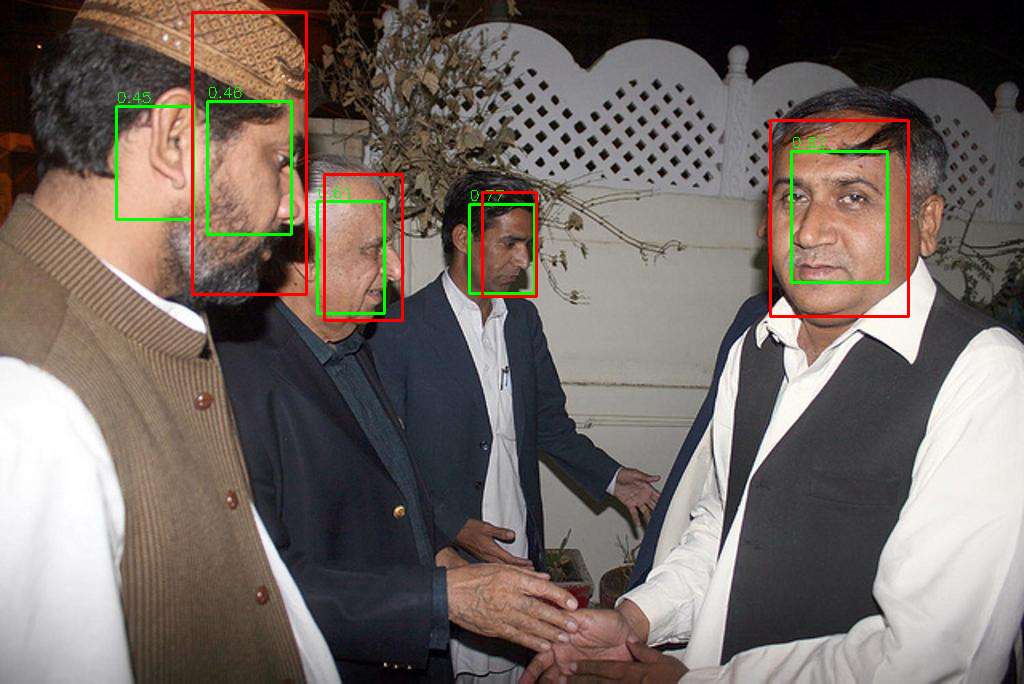

In [34]:
# --- run it on best weights ---
_ = load_best_into(model)  # model is your instantiated TinyFaceDetector already on device
visualize_from_val_index(model, val_ds, idx=123, img_root=DATA_VAL_IMAGES,
                         score_thresh=0.45, nms_thresh=0.5)

In [34]:
# Identify yourself once
!git config --global user.email "pavao.jancijev@email.com"
!git config --global user.name "pavopija"

import getpass, os
os.environ["GITHUB_TOKEN"] = getpass.getpass("GitHub token: ")

# Clone your repo
%cd /content
!git clone https://github.com/pavopija/TinyFaceDetector.git
%cd /content/REPO

# Copy the notebook in
!cp "https://colab.research.google.com/drive/13Nvwjc1YxHWVfT6Nwvwmn_4K1bKuNSIj?usp=sharing" .


# Commit + push
!git add .
!git commit -m "Add/update notebook"
!git push


GitHub token: ··········
/content
fatal: destination path 'TinyFaceDetector' already exists and is not an empty directory.
[Errno 2] No such file or directory: '/content/REPO'
/content
cp: cannot stat 'https://colab.research.google.com/drive/13Nvwjc1YxHWVfT6Nwvwmn_4K1bKuNSIj?usp=sharing': No such file or directory
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
